In [1]:
import os
import sys
import csv
import json
import moment
import pymysql
import datetime

import numpy as np
import scipy as sp
import scipy.stats as stats
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict

import statsmodels.api as sm

%matplotlib inline

In [2]:
# data_file_name = 'data/pandas_df_v2_2020-04-25.pkl'
# data_file_name = 'data/pandas_df_v3_2020-04-25.pkl'
data_file_name = 'data/pandas_df_v3-1_2020-04-25.pkl'

df = pd.read_pickle(data_file_name)
_version, date_retrieved = data_file_name.split('_df_')[1].split('.')[0].split('_')
print(_version, date_retrieved)

v3-1 2020-04-25


In [3]:
df.describe()

,pat_mrn_id,intubated,days_to_intubation,died,days_to_death,age,sex,macula,compl_def,coagulation,...,cad,refctrl,race_black,race_asian,race_white,race_other,race_declined,eth_hispanic,eth_nonhispanic,eth_declinedother
count,1.111600e+04,6531.000000,6531.000000,6531.000000,6531.000000,11116.000000,11116.000000,11116.000000,11116.000000,11116.000000,...,11116.000000,11116.000000,11116.000000,11116.000000,11116.000000,11116.000000,11116.000000,11116.000000,11116.000000,11116.000000
mean,1.103351e+09,0.092176,18.861736,0.090951,19.773695,51.996838,0.447733,0.011335,0.000810,0.181810,...,0.237136,0.091310,0.211857,0.026718,0.313152,0.268262,0.180011,0.316661,0.394476,0.288863
std,1.336290e+08,0.289296,12.746979,0.287561,11.916822,22.618502,0.497283,0.105866,0.028444,0.385705,...,0.425345,0.288062,0.408642,0.161266,0.463797,0.443075,0.384214,0.465195,0.488760,0.453254
min,1.000001e+09,0.000000,-75.000000,0.000000,-220.000000,0.002738,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.004833e+09,0.000000,10.000000,0.000000,11.000000,34.718001,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.010136e+09,0.000000,20.000000,0.000000,20.000000,53.533196,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.200942e+09,0.000000,28.000000,0.000000,28.000000,69.492129,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
max,1.400038e+09,1.000000,84.000000,1.000000,234.000000,120.312115,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## In the dataset overall

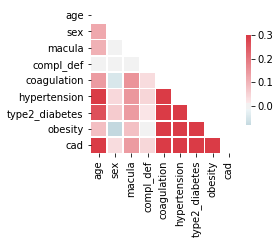

In [4]:
# Compute the correlation matrix

covariates = ['age', 'sex', 'macula', 'compl_def', 'coagulation', 'hypertension', 'type2_diabetes', 'obesity', 'cad']

# for covar1 in covariates:
#     for covar2 in covariates:
#         print(covar1, covar2, stats.spearmanr(df[covar1], df[covar2]))

corr = df[covariates].corr('spearman')

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(4, 5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .3});

plt.tight_layout()
plt.savefig('figures/correlation_heatmap_allpts_%s_%s.pdf' % (_version, date_retrieved))

## Only in COVID+

In [5]:
# NaN indicate people who were not covid positive
covidpos = df.dropna()

# remove patients who were intubated before they were diagnosed
covidpos = covidpos[covidpos["days_to_intubation"] >= 0]

# remove patients that died before they were diagnosed
covidpos = covidpos[covidpos["days_to_death"] >= 0]

# remove patients who were intubated or died more than 30 days later
covidpos = covidpos[covidpos["days_to_intubation"] < 90]
covidpos = covidpos[covidpos["days_to_death"] < 90]

covidpos.describe()

,pat_mrn_id,intubated,days_to_intubation,died,days_to_death,age,sex,macula,compl_def,coagulation,...,cad,refctrl,race_black,race_asian,race_white,race_other,race_declined,eth_hispanic,eth_nonhispanic,eth_declinedother
count,6.397000e+03,6397.000000,6397.000000,6397.000000,6397.000000,6397.000000,6397.000000,6397.000000,6397.000000,6397.000000,...,6397.000000,6397.000000,6397.000000,6397.000000,6397.000000,6397.000000,6397.000000,6397.000000,6397.000000,6397.000000
mean,1.095011e+09,0.075191,19.607629,0.085040,19.901516,57.134029,0.497264,0.013756,0.000625,0.184305,...,0.244802,0.113647,0.221510,0.023136,0.283727,0.280131,0.191496,0.339534,0.369079,0.291387
std,1.319922e+08,0.263721,11.330646,0.278963,11.141045,19.877320,0.500032,0.116487,0.025000,0.387763,...,0.430004,0.317407,0.415295,0.150347,0.450841,0.449098,0.393509,0.473588,0.482593,0.454437
min,1.000011e+09,0.000000,0.000000,0.000000,0.000000,0.002738,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.004378e+09,0.000000,11.000000,0.000000,11.000000,41.478439,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.009221e+09,0.000000,20.000000,0.000000,20.000000,58.510609,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.200224e+09,0.000000,28.000000,0.000000,28.000000,72.005476,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
max,1.400038e+09,1.000000,84.000000,1.000000,83.000000,120.202601,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


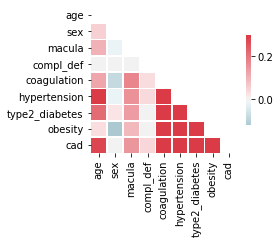

In [6]:
# Compute the correlation matrix

covariates = ['age', 'sex', 'macula', 'compl_def', 'coagulation', 'hypertension', 'type2_diabetes', 'obesity', 'cad']

# for covar1 in covariates:
#     for covar2 in covariates:
#         print(covar1, covar2, stats.spearmanr(df[covar1], df[covar2]))

corr = covidpos[covariates].corr('spearman')

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(4, 5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .3});

plt.tight_layout()
plt.savefig('figures/correlation_heatmap_covidpos_%s_%s.pdf' % (_version, date_retrieved))

In [7]:
corr

,age,sex,macula,compl_def,coagulation,hypertension,type2_diabetes,obesity,cad
age,1.000000,0.054692,0.102871,0.001239,0.123617,0.323293,0.218046,0.033661,0.279485
sex,0.054692,1.000000,-0.018143,0.000137,-0.080857,-0.018237,0.022893,-0.120941,-0.007792
macula,0.102871,-0.018143,1.000000,-0.002954,0.175771,0.153864,0.139970,0.094255,0.151252
compl_def,0.001239,0.000137,-0.002954,1.000000,0.036494,0.038168,0.008679,-0.009396,0.043934
coagulation,0.123617,-0.080857,0.175771,0.036494,1.000000,0.458849,0.299638,0.323601,0.457003
hypertension,0.323293,-0.018237,0.153864,0.038168,0.458849,1.000000,0.493478,0.392933,0.630846
type2_diabetes,0.218046,0.022893,0.139970,0.008679,0.299638,0.493478,1.000000,0.301614,0.444793
obesity,0.033661,-0.120941,0.094255,-0.009396,0.323601,0.392933,0.301614,1.000000,0.354929
cad,0.279485,-0.007792,0.151252,0.043934,0.457003,0.630846,0.444793,0.354929,1.000000
